# rule based feature 추출

module import

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Anode

In [2]:
# 양극 정상 데이터 파일명 확인
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Normal

[PosixPath('../data/230507/Anode/Normal/1.csv'),
 PosixPath('../data/230507/Anode/Normal/10.csv'),
 PosixPath('../data/230507/Anode/Normal/11.csv'),
 PosixPath('../data/230507/Anode/Normal/12.csv'),
 PosixPath('../data/230507/Anode/Normal/14.csv'),
 PosixPath('../data/230507/Anode/Normal/15.csv'),
 PosixPath('../data/230507/Anode/Normal/16.csv'),
 PosixPath('../data/230507/Anode/Normal/17.csv'),
 PosixPath('../data/230507/Anode/Normal/18.csv'),
 PosixPath('../data/230507/Anode/Normal/19.csv'),
 PosixPath('../data/230507/Anode/Normal/2.csv'),
 PosixPath('../data/230507/Anode/Normal/20.csv'),
 PosixPath('../data/230507/Anode/Normal/20230412_110032_0__03_Total.csv'),
 PosixPath('../data/230507/Anode/Normal/21.csv'),
 PosixPath('../data/230507/Anode/Normal/22.csv'),
 PosixPath('../data/230507/Anode/Normal/23.csv'),
 PosixPath('../data/230507/Anode/Normal/24.csv'),
 PosixPath('../data/230507/Anode/Normal/25.csv'),
 PosixPath('../data/230507/Anode/Normal/26.csv'),
 PosixPath('../data/230507/

In [3]:
# 양극 정상 데이터 파일 총 갯수
len(Anode_Normal)

35

In [4]:
# 양극 비정상 데이터 파일 확인
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])
Anode_Abnormal

[PosixPath('../data/230507/Anode/Abnormal/20230412_105553_0__01_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_105804_0__02_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110249_0__04_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110451_0__05_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110735_0__06_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110928_0__07_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111152_0__08_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111719_0__09_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111935_0__10_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112153_0__11_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112415_0__12_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112642_0__13_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112855_0__14_Total.csv'),

In [5]:
# 양극 비정상 데이터 파일 총 갯수
len(Anode_Abnormal)

18

In [6]:
# 그래프 시각화를 위한 함수
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [7]:
# metric 계산 함수 (TP, TN, FP, FN, Precision, Recall, F1-score)
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


# Point Adjustment를 위한 label 수정 함수
def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


# Point Adjustment %K F1-score 계산 함수 (K=100 -> Point F1-score, K=0 -> Point Adjustment F1-score)
def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

    
# Anomaly score sequence의 f1-score 도출
def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t

    
# best f1-search 함수
def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Train, Test 생성

In [8]:
# 정상 데이터프레임 구성
Anode_Normal_df = pd.DataFrame()

# 정상 데이터의 Rule-based feature 추출
for i, c in enumerate(Anode_Normal):
    extractor = ExtractFeatures(str(c))    # Rule-based feature 추출하는 클래스 선언
    extracted_data = extractor.extract(extractor.data, verbose=False)    # Rule-based feature 추출
    # 추출된 Rule-based feature 형 변환
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 0 } 
                       for d in extracted_data ]
    # 비정상 데이터프레임에 추출된 데이터 추가
    Anode_Normal_df = pd.concat([Anode_Normal_df, pd.DataFrame(extracted_data_)])

warning index: 40140
warning index: 42886
warning index: 43436
warning index: 50028
warning index: 61535
warning index: 64282
Detected bead num: 54
Extracted 54 beads from data
warning index: 50276
warning index: 50826
warning index: 51375
warning index: 51924
warning index: 52473
warning index: 53022
warning index: 53572
warning index: 54122
warning index: 55221
warning index: 55770
warning index: 56320
warning index: 56869
warning index: 57418
warning index: 57968
warning index: 58517
warning index: 59066
warning index: 59615
warning index: 60164
warning index: 60713
warning index: 61263
warning index: 61812
warning index: 62362
warning index: 62911
warning index: 63461
Detected bead num: 54
Extracted 54 beads from data
warning index: 41577
error index: 41676
warning index: 42126
error index: 42225
warning index: 42675
warning index: 43224
warning index: 43773
warning index: 44323
warning index: 44873
warning index: 45422
warning index: 45972
warning index: 46521
error index: 46620
w

Detected bead num: 54
Extracted 54 beads from data
warning index: 45317
warning index: 45867
warning index: 46416
warning index: 46965
warning index: 48063
warning index: 49163
warning index: 49712
warning index: 50262
warning index: 51361
warning index: 51910
warning index: 53009
warning index: 53558
warning index: 55205
warning index: 56304
warning index: 59051
warning index: 59600
warning index: 60120
warning index: 60669
warning index: 61768
warning index: 62317
warning index: 63416
warning index: 63966
warning index: 65613
warning index: 66163
warning index: 68361
warning index: 69459
Detected bead num: 54
Extracted 54 beads from data
error index: 55118
error index: 55668
warning index: 56118
error index: 56217
warning index: 56667
error index: 56766
warning index: 57216
error index: 57315
warning index: 57765
error index: 57864
warning index: 58315
error index: 58414
warning index: 58865
error index: 58964
error index: 59513
error index: 60063
warning index: 60513
error index: 60

Detected bead num: 54
Extracted 54 beads from data
warning index: 41622
warning index: 42172
warning index: 43819
warning index: 44368
warning index: 48764
warning index: 54257
Detected bead num: 54
Extracted 54 beads from data
warning index: 51916
warning index: 72213
warning index: 80451
warning index: 81000
Detected bead num: 54
Extracted 54 beads from data
error index: 66410
error index: 66960
error index: 67509
error index: 68607
error index: 70256
error index: 71355
error index: 71904
error index: 76846
Detected bead num: 54
Extracted 54 beads from data


,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,3.292055,2.932646,3.344641,0.043745,100,322.669751,5.297992,16,4.150539,0.380110,...,0.0,1,0.063747,10.542135,0.215438,26,0.0,2,0.147684,0
1,3.293162,2.964636,3.332362,0.039373,100,323.246546,7.750054,17,6.589675,0.278433,...,0.0,3,0.303926,8.392543,0.187928,33,0.0,4,0.359773,0
2,3.294754,2.979177,3.333655,0.037731,100,323.408437,7.974320,20,6.782272,0.272605,...,0.0,2,0.141417,12.545466,0.214143,28,0.0,3,0.328167,0
3,3.292459,2.942340,3.333978,0.042657,100,323.347689,8.540802,19,7.442791,0.336719,...,0.0,3,0.224268,12.438227,0.205081,30,0.0,3,0.284476,0
4,3.293290,2.975946,3.344965,0.041039,100,323.456910,8.267094,21,6.920903,0.297214,...,0.0,4,0.268263,8.251067,0.174658,32,0.0,3,0.266351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,3.293610,2.916166,3.375016,0.047337,100,322.788018,7.625641,23,6.278804,0.309519,...,0.0,2,0.125226,9.277974,0.227736,45,0.0,3,0.413286,0
50,3.294912,2.938462,3.341410,0.043516,100,323.008391,7.397821,22,6.084269,0.458796,...,0.0,3,0.206783,13.249178,0.185986,39,0.0,3,0.318782,0
51,3.290274,2.940078,3.330100,0.043143,100,322.594782,8.458076,22,7.081832,0.453939,...,0.0,3,0.275754,7.450686,0.201521,41,0.0,3,0.378010,0
52,3.291449,2.929414,3.332039,0.043966,99,320.381763,6.923760,19,5.735913,0.483082,...,0.0,4,0.397464,7.090268,0.202815,38,0.0,4,0.494734,0


In [9]:
# 비정상 데이터프레임 구성
Anode_Abnormal_df = pd.DataFrame()

# 비정상 데이터의 Rule-based feature 추출
for i, c in enumerate(Anode_Abnormal):
    extractor = ExtractFeatures(str(c))    # Rule-based feature 추출하는 클래스 선언
    extracted_data = extractor.extract(extractor.data, verbose=False)    # Rule-based feature 추출
    # 추출된 Rule-based feature 형 변환
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 1 } 
                       for d in extracted_data ]
    # 비정상 데이터프레임에 추출된 데이터 추가
    Anode_Abnormal_df = pd.concat([Anode_Abnormal_df, pd.DataFrame(extracted_data_)])

warning index: 43496
error index: 45840
error index: 46290
error index: 48987
error index: 52131
error index: 52581
error index: 53030
error index: 53480
error index: 55277
error index: 55697
error index: 56596
error index: 57944
error index: 58843
error index: 60190
error index: 61089
error index: 63336
error index: 66930
Detected bead num: 54
Extracted 54 beads from data
warning index: 41651
warning index: 42151
warning index: 42650
warning index: 43149
warning index: 43648
warning index: 66587
warning index: 67087
warning index: 68085
Detected bead num: 54
Extracted 54 beads from data
warning index: 40118
warning index: 41317
error index: 41416
warning index: 41916
error index: 43813
warning index: 44913
warning index: 45513
error index: 47410
error index: 51005
warning index: 61066
Detected bead num: 54
Extracted 54 beads from data
error index: 39049
error index: 40348
error index: 40997
error index: 41646
error index: 42295
error index: 42945
error index: 43595
error index: 44244


warning index: 31889
warning index: 32439
warning index: 32988
warning index: 33537
warning index: 34635
warning index: 35185
warning index: 36834
warning index: 37383
warning index: 40130
warning index: 40679
warning index: 41228
warning index: 41777
warning index: 42326
warning index: 42876
warning index: 46692
error index: 55580
Detected bead num: 54
Extracted 54 beads from data
Detected bead num: 54
Extracted 54 beads from data
Detected bead num: 54
Extracted 54 beads from data
warning index: 37376
warning index: 57123
Detected bead num: 54
Extracted 54 beads from data
warning index: 34579
warning index: 35129
warning index: 59269
warning index: 59818
warning index: 60368
Detected bead num: 54
Extracted 54 beads from data


,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,2.543194,2.342603,2.607896,0.032048,100,248.138572,7.113772,21,4.039052,0.072166,...,0.0,-1,0.000000,4.818142,0.033224,29,0.0,-1,0.000000,1
1,2.543351,2.382672,2.612743,0.026582,100,248.609055,8.275819,19,3.255736,0.072813,...,0.0,0,0.000000,4.802099,0.034195,27,0.0,-1,0.000000,1
2,2.538725,2.389134,2.587538,0.029948,100,250.427009,8.169826,26,3.359144,0.098394,...,0.0,0,0.000000,4.580637,0.039374,33,0.0,1,0.039374,1
3,2.538163,2.368454,2.579460,0.032349,99,247.835909,7.882223,26,6.249075,0.167366,...,0.0,2,0.142065,3.788013,0.123522,62,0.0,2,0.179078,1
4,2.537200,2.349712,2.601110,0.034977,99,247.593238,9.334135,20,3.762112,0.051442,...,0.0,-1,0.000000,3.565846,0.029341,22,0.0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,3.272047,3.029586,3.394081,0.047201,99,319.841799,9.655993,20,8.302047,0.413786,...,0.0,4,0.711236,10.025437,0.169480,35,0.0,4,0.426121,1
50,3.272138,3.010521,3.354335,0.040638,100,321.434737,9.663425,17,8.396729,0.323767,...,0.0,0,0.000000,12.357873,0.162036,30,0.0,1,0.063324,1
51,3.268527,3.018599,3.324284,0.037464,100,321.045357,7.331898,16,6.208035,0.254471,...,0.0,2,0.133970,12.234519,0.191811,27,0.0,3,0.313928,1
52,3.267759,2.997919,3.341733,0.038239,100,321.109343,9.511868,17,8.335654,0.432243,...,0.0,8,0.589628,14.953382,0.219645,37,0.0,3,0.299688,1


In [10]:
# 정상 데이터의 0.8은 train, 나머지 0.2는 비정상 데이터와 test에 사용
split_rate = 0.8
train_index = int(len(Anode_Normal)*split_rate) * 54
Anode_Train = Anode_Normal_df.iloc[:train_index]
Anode_Test = pd.concat([Anode_Normal_df.iloc[train_index:], Anode_Abnormal_df])

In [11]:
Anode_Train

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,3.292055,2.932646,3.344641,0.043745,100,322.669751,5.297992,16,4.150539,0.380110,...,0.0,1,0.063747,10.542135,0.215438,26,0.0,2,0.147684,0
1,3.293162,2.964636,3.332362,0.039373,100,323.246546,7.750054,17,6.589675,0.278433,...,0.0,3,0.303926,8.392543,0.187928,33,0.0,4,0.359773,0
2,3.294754,2.979177,3.333655,0.037731,100,323.408437,7.974320,20,6.782272,0.272605,...,0.0,2,0.141417,12.545466,0.214143,28,0.0,3,0.328167,0
3,3.292459,2.942340,3.333978,0.042657,100,323.347689,8.540802,19,7.442791,0.336719,...,0.0,3,0.224268,12.438227,0.205081,30,0.0,3,0.284476,0
4,3.293290,2.975946,3.344965,0.041039,100,323.456910,8.267094,21,6.920903,0.297214,...,0.0,4,0.268263,8.251067,0.174658,32,0.0,3,0.266351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,3.287171,3.010521,3.326223,0.034268,100,323.580670,7.373908,24,6.086531,0.301424,...,0.0,2,0.159551,9.654862,0.168832,36,0.0,3,0.296774,0
50,3.289587,3.077086,3.339794,0.030379,100,323.948391,7.068208,22,5.773075,0.406339,...,0.0,4,0.428549,10.577385,0.204434,33,0.0,3,0.259555,0
51,3.292795,3.074825,3.346257,0.029596,100,324.119657,8.929552,23,7.714237,0.373957,...,0.0,2,0.190313,11.749349,0.225794,38,0.0,3,0.349852,0
52,3.292822,3.046389,3.345934,0.032072,100,324.107374,4.971610,16,3.911084,0.375900,...,0.0,2,0.116160,10.086666,0.214790,31,0.0,3,0.300011,0


In [12]:
Anode_Test

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,3.290994,3.097444,3.333009,0.028340,99,321.585758,8.588952,20,7.442468,0.680930,...,0.0,54,6.117315,15.737818,0.235827,45,0.0,4,0.397965,0
1,3.290126,3.110692,3.318144,0.026868,100,324.098006,5.778516,17,4.682120,0.288148,...,0.0,2,0.133322,11.673075,0.195695,24,0.0,3,0.216186,0
2,3.288218,3.105522,3.330100,0.030732,100,323.854360,7.008748,18,5.852893,0.325710,...,0.0,5,0.277609,9.508387,0.212201,48,0.0,2,0.146066,0
3,3.288699,3.086134,3.348196,0.032648,99,321.736656,7.395882,17,6.268787,0.478548,...,0.0,5,0.381229,12.428924,0.167214,26,0.0,4,0.366570,0
4,3.291419,3.128142,3.344641,0.028221,99,321.995491,8.315244,20,7.084418,0.341576,...,0.0,6,0.453718,11.017516,0.187280,30,0.0,4,0.352978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,3.272047,3.029586,3.394081,0.047201,99,319.841799,9.655993,20,8.302047,0.413786,...,0.0,4,0.711236,10.025437,0.169480,35,0.0,4,0.426121,1
50,3.272138,3.010521,3.354335,0.040638,100,321.434737,9.663425,17,8.396729,0.323767,...,0.0,0,0.000000,12.357873,0.162036,30,0.0,1,0.063324,1
51,3.268527,3.018599,3.324284,0.037464,100,321.045357,7.331898,16,6.208035,0.254471,...,0.0,2,0.133970,12.234519,0.191811,27,0.0,3,0.313928,1
52,3.267759,2.997919,3.341733,0.038239,100,321.109343,9.511868,17,8.335654,0.432243,...,0.0,8,0.589628,14.953382,0.219645,37,0.0,3,0.299688,1


In [13]:
# 데이터 X, Y(label) 분리
Anode_Train_y = Anode_Train['label']
Anode_Train_X = Anode_Train.drop('label', axis=1)
Anode_Test_y = Anode_Test['label']
Anode_Test_X = Anode_Test.drop('label', axis=1)

### Isolation Forest

In [14]:
# Isolation Forest 모델 선언 및 학습
IF_clf=IsolationForest(random_state=72).fit(Anode_Train_X)
# Isolation Forest를 통한 anomaly score 도출
IF_anomaly_score = IF_clf.score_samples(Anode_Test_X)

In [19]:
# Best F1 search 방법에 따른 threshold 도출
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
# 해당 threshold를 통한 성능
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.9667, F1: 0.9440, Precision: 0.9336, Recall: 0.9547


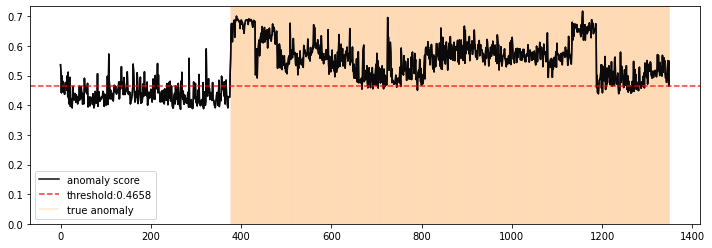

In [20]:
# Anomaly score 그래프 시각화
check_graph(-IF_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

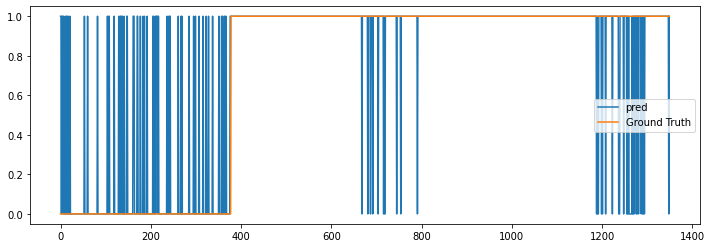

In [21]:
# 예측 레이블과 정답 레이블 비교 그래프
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [22]:
# 각 비드 별 label 갯수 확인
bead_counter = []
for i in range(len(IF_pred)//54):
    bead_counter.append(dict(Counter(IF_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 12, False: 42}, {False: 50, True: 4}, {True: 11, False: 43}, {True: 15, False: 39}, {False: 46, True: 8}, {False: 48, True: 6}, {False: 44, True: 10}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 50, False: 4}, {True: 48, False: 6}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 11, True: 43}, {True: 33, False: 21}, {True: 53, False: 1}]


### One-class SVM

In [23]:
# One class SVM 모델 선언 및 학습
OCS_clf = OneClassSVM().fit(Anode_Train_X)
# One class SVM를 통한 anomaly score 도출
OCS_anomaly_score = OCS_clf.score_samples(Anode_Test_X)

In [27]:
# Best F1 search 방법에 따른 threshold 도출
# One class SVM의 경우 작을수록 anomaly
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
# 해당 threshold를 통한 성능
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.9252, F1: 0.9043, Precision: 0.9361, Recall: 0.8745


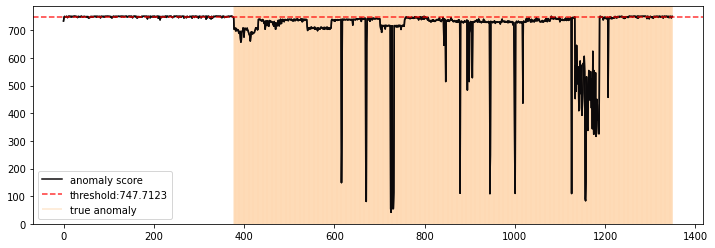

In [28]:
# Anomaly score 그래프 시각화
check_graph(OCS_anomaly_score, np.array(Anode_Test_y), threshold=-threshold)
plt.show()

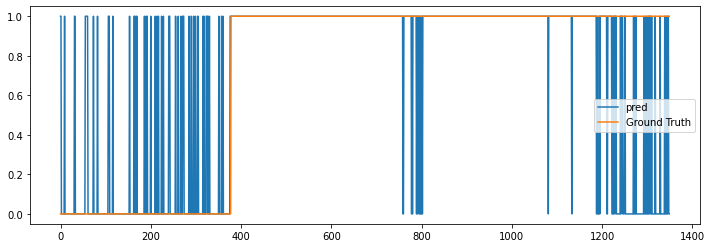

In [29]:
# 예측 레이블과 정답 레이블 비교 그래프
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [30]:
# 각 비드 별 label 갯수 확인
bead_counter = []
for i in range(len(OCS_pred)//54):
    bead_counter.append(dict(Counter(OCS_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 5, False: 49}, {False: 44, True: 10}, {True: 3, False: 51}, {False: 44, True: 10}, {False: 45, True: 9}, {False: 42, True: 12}, {True: 9, False: 45}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 43, False: 11}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 52, False: 2}, {True: 54}, {False: 22, True: 32}, {False: 45, True: 9}, {False: 42, True: 12}]


### MoG

In [31]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Gaussian Mixture 모델 선언 및 학습
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Anode_Train_X)
# Gaussian Mixture를 통한 anomaly score 도출
MoG_anomaly_score = gmm.score_samples(Anode_Test_X)

AUROC: 0.9977, F1: 0.1053, Precision: 1.0000, Recall: 0.0556


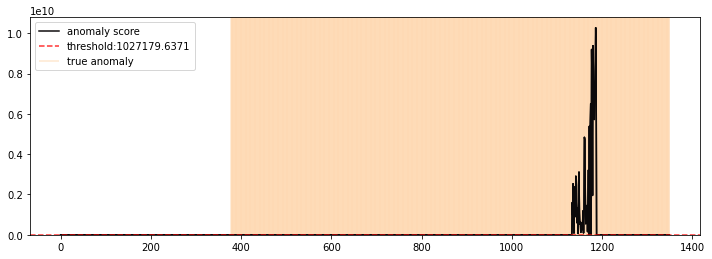

In [34]:
# Best F1 search 방법에 따른 threshold 도출
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
# 해당 threshold를 통한 성능
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
# Anomaly score 그래프 시각화
check_graph(-MoG_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

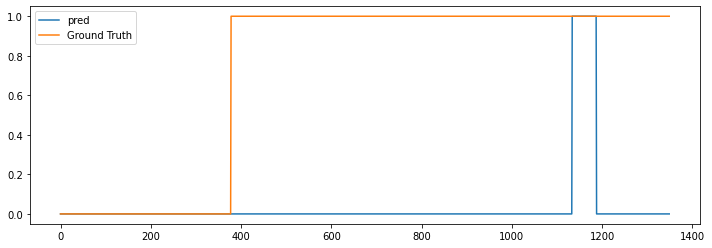

In [35]:
# 예측 레이블과 정답 레이블 비교 그래프
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [37]:
# 각 비드 별 label 갯수 확인
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {True: 54}, {False: 54}, {False: 54}, {False: 54}]


### Parzen windows

In [39]:
# Parzen windows 모델 선언 및 학습
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Anode_Train_X)

AUROC: 0.9499, F1: 0.8377, Precision: 0.9972, Recall: 0.7222


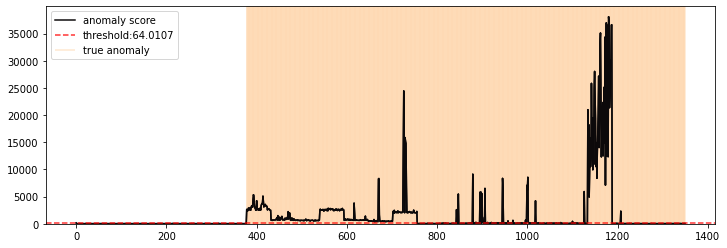

In [40]:
# 범위의 각 값에서 밀도를 추정
# Parzen windows를 통한 anomaly score 도출
# Parzen windows에서는 밀도가 낮을수록 anomaly
density = kde.score_samples(Anode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
# 해당 threshold를 통한 성능
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
# Anomaly score 그래프 시각화
check_graph(-density, np.array(Anode_Test_y), threshold=threshold)
plt.show()

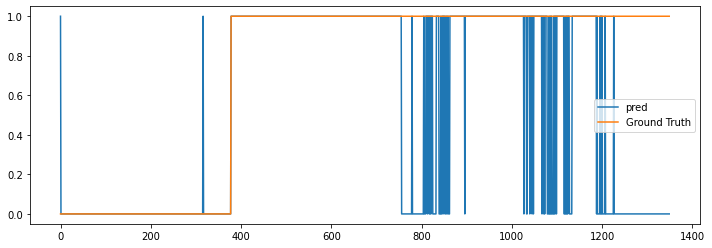

In [41]:
# 예측 레이블과 정답 레이블 비교 그래프
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [42]:
# 각 비드 별 label 갯수 확인
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 1, False: 53}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 53, True: 1}, {False: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 52, True: 2}, {True: 28, False: 26}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 44, False: 10}, {False: 25, True: 29}, {True: 54}, {False: 48, True: 6}, {False: 54}, {False: 54}]


### IF precision test

가장 좋은 성능을 보인 Isolation Foreset 모델을 사용해서 precision 값에 따른 metric 결과들을 비교합니다.

In [151]:
# threshold 시작과 끝 지정
start = np.max(-IF_anomaly_score)   # max값을 시작으로 지정
end = np.min(-IF_anomaly_score)    # min값을 끝으로 지정
step = -(start-end)/1000    # min, max 사이를 1000 스텝으로 확인

# 각 thresold 마다 metric 결과 기록
history = {}

for i in np.arange(np.max(-IF_anomaly_score), np.min(-IF_anomaly_score), step):
    target = calc_seq(-IF_anomaly_score, np.array(Anode_Test_y), i, K=100)
    # precision이 0.9 이상인 경우만 기록
    if target[1] >= 0.9:  
        history[f"{target[1]:.2f}"] = {
            'threshold': f"{i:.4f}",
            'f1': f"{target[0]:.4f}",
            'precision': f"{target[1]:.4f}",
            'recall': f"{target[2]:.4f}"
        }
    else:
        break

In [153]:
pre_test = pd.DataFrame.from_dict(data=history, orient='columns')
pre_test

,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90
threshold,0.5583,0.5117,0.4998,0.4846,0.4793,0.4767,0.4684,0.4638,0.4579,0.4522,0.4513
f1,0.6775,0.8669,0.8885,0.9215,0.9269,0.9305,0.9395,0.9434,0.9436,0.9428,0.9400
precision,0.9960,0.9856,0.9754,0.9651,0.9552,0.9458,0.9357,0.9274,0.9166,0.9053,0.9002
recall,0.5134,0.7737,0.8158,0.8817,0.9002,0.9156,0.9434,0.9599,0.9722,0.9835,0.9835


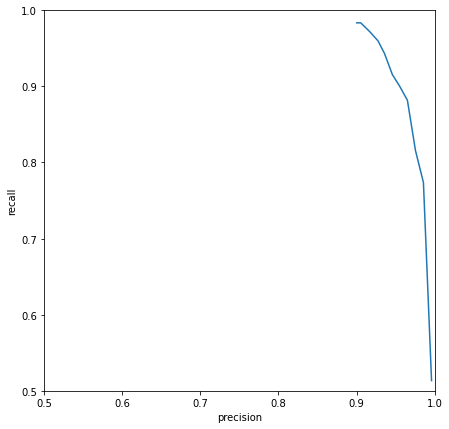

In [171]:
plt.figure(figsize=(7, 7))
plt.plot(pre_test.loc['precision'].astype(float), pre_test.loc['recall'].astype(float))
plt.axis([0.5, 1, 0.5, 1])
plt.xlabel('precision')
plt.ylabel('recall')
# plt.xlim([0.5, 1])
# plt.ylim([0.5, 1])
plt.show()

---